# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

Ten notatnik zalicza się do grupy zestawów zadań, na podstawie których odbywa się zaliczenie ćwiczeń i podlega zwrotowi do oceny w ustalonym na zajęciach terminie.

Uwagi ogólne:
- Podczas wykonywania zadań należy korzystać wyłącznie z pakietów zaimportowanych na początku notatnika oraz z pakietów wchodzących w skład standardowej biblioteki Pythona, które można zaimportować samodzielnie we wskazanej komórce.
- Swoje rozwiązania należy wprowadzać wyłącznie w miejce następujących fragmentów kodu:<br/> ` # YOUR CODE HERE`<br/> ` raise NotImplementedError()`<br/> Nie należy w żaden sposób modyfikować pozostałych fragmentów kodu oraz elementów notatnika, w szczególności dodawać lub usuwać komórek oraz zmieniać nazwy pliku.
- Jeżeli zestaw zadań wymaga skorzystania z funkcji przygotowanych w ramach wcześniejszych zestawów zadań należy je umieścić we wskazanej komórce.
- Wszystkie wykresy powinny być wykonane w jednolitym, przejrzystym i czytelnym stylu, mieć nadane tytuły, opisane osie oraz odpowiednio dobrany rozmiar, wielkość punktów i grubość linii. Proporcje osi wykresów przedstawiających rozkłady punktów powinny być dobrane tak, aby wykresy odzwierciedlały rzeczywisty rozkład punktów w przestrzeni.
- Zadania, które powodują wyświetlenie komunikatu o błędzie przerywającym wykonywanie kodu nie podlegają ocenie.

Przed odesłaniem zestawu zadań do oceny proszę uzupełnić komórkę z danymi autorów rozwiązania (`NAME` - nazwa grupy, `COLLABORATORS` - imiona, nazwiska i numery indeksów członków grupy) oraz upewnić się, że notatnik działa zgodnie z oczekiwaniami. W tym celu należy skorzystać z opcji **Restart Kernel and Run All Cells...** dostępnej na górnej belce notatnika pod symbolem $\blacktriangleright\blacktriangleright$. 

---

## Zestaw zadań 5: Badanie relacji między punktami (część 2)

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów
sns.set() 
sns.set_theme(style="whitegrid")
from math import floor, ceil

In [4]:
def regular_on_rectangle(grid, random_component, x_lim, y_lim):
    """
    Parameters
    -------
    grid: list
        Lista określająca liczbę punktów w poziomie i pionie.
        Przykład: [10, 10]
    random_component: float
        Liczba z przedziału [0, 1] określająca wielkość komponentu losowego.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    # 1
    dx = (x_lim[1] - x_lim[0]) / grid[0]
    dy = (y_lim[1] - y_lim[0]) / grid[1]

    x = np.linspace(x_lim[0] + 0.5 * dx, x_lim[1] - 0.5 * dx, grid[0])
    y = np.linspace(y_lim[0] + 0.5 * dy, y_lim[1] - 0.5 * dy, grid[1])

    # 2
    xy = []
    xx, yy = np.meshgrid(x, y, indexing="xy")

    for xxx, yyy in zip(xx, yy):
        for xxxx, yyyy in zip(xxx, yyy):
            xy.append([xxxx + random_component * np.random.uniform(-0.5 * dx, 0.5 * dx),
                       yyyy + random_component * np.random.uniform(-0.5 * dy, 0.5 * dy)])

    return pd.DataFrame(data=xy, columns=["X", "Y"])

def homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim):
    """
    Parameters
    -------
    intensity: float
        Liczba dodatnia określająca intensywność procesu punktowego.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    a = (x_lim[1] - x_lim[0]) * (y_lim[1] - y_lim[0])
    n = np.random.poisson(intensity * a, 1)[0]
    df = []
    
    for nn in range(n):
        df.append([np.random.uniform(x_lim[0], x_lim[1]), np.random.uniform(y_lim[0], y_lim[1])])
        
    return pd.DataFrame(data=df, columns=["X", "Y"])


def materna_on_rectangle(parent_intensity, daughter_intensity, cluster_radius, x_lim, y_lim):
    """
    Parameters
    -------
    parent_intensity: float
        Liczba dodatnia określająca intensywność macierzystego procesu punktowego.
    daughter_intensity: float
        Liczba dodatnia określająca intensywność potomnego procesu punktowego.
    cluster_radius: float
        Liczba dodatnia określająca promień generowanych klastrów.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    #1
    x_lim_expanded = [x_lim[0] - cluster_radius, x_lim[1] + cluster_radius]
    y_lim_expanded = [y_lim[0] - cluster_radius, y_lim[1] + cluster_radius]
    #2
    points = homogeneous_poisson_on_rectangle(parent_intensity, x_lim_expanded, y_lim_expanded)
    #3
    new_points = pd.DataFrame()
    
    for x, y in zip(points["X"], points["Y"]):
        new_distribution = homogeneous_poisson_on_rectangle(daughter_intensity, [x-cluster_radius, x+cluster_radius], [y-cluster_radius, y+cluster_radius])
        new_distribution = new_distribution[(new_distribution["X"] - x) ** 2 + (new_distribution["Y"] - y) ** 2 <= cluster_radius]
        new_points = pd.concat([new_points, new_distribution], ignore_index=True)
        
    new_points = new_points[new_points["X"] >= x_lim[0]]    
    new_points = new_points[new_points["X"] <= x_lim[1]]
    new_points = new_points[new_points["Y"] >= y_lim[0]]
    new_points = new_points[new_points["Y"] <= y_lim[1]]
    
    return new_points

def fry_plot_data(points):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    
    Returns
    -------
    fry_points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """    
    df = pd.DataFrame([], columns=["X", "Y"])
    for x, y in zip(points["X"], points["Y"]):
        coords_x = points["X"]-x
        coords_y = points["Y"]-y
        df = pd.concat([df, pd.DataFrame({"X":coords_x, "Y":coords_y})])
    return df

### Przygotowanie danych

Korzystając z funkcji przygotowanych w ramach pierwszego zestawu zadań wygeneruj rozkłady punktowe o podanych paramatrach.

Jednorodny rozkład Poissona:
 - intensywność procesu: 2.5

Rozkład regularny z komponentem losowym:
- liczba punktów w poziomie i w pionie: 15x15
- komponent losowy: 0.75

Rozkład Materna:
 - intensywność procesu macierzystego: 0.3
 - intensywność procesu potomnego: 5
 - promień klastra: 0.75
 
Parametry identyczne dla wszystkich rozkładów:
 - zakres wartości współrzędnej x: [0, 10]
 - zakres wartości współrzędnej y: [0, 10]
 
UWAGA! Dane do wygenerowania są identyczne jak w poprzednim zestawie zadań.

In [5]:
lims = [0, 10]
regular = regular_on_rectangle([15, 15], 0.75, lims, lims)
poisson = homogeneous_poisson_on_rectangle(2.5, lims, lims)
materna = materna_on_rectangle(0.3, 5, 0.75, lims, lims)

### Zadanie 1: Funkcja G (25 pkt)

Przygotuj funkcję `g_function()`, która będzie generować dane niezbędne do wykonania wykresu funkcji G analizowanego rozkładu punktów oraz funkcję `g_function_poisson()`, która będzie generować dane niezbędne do wykonania wykresu teoretycznej funkcji G jednorodnego rozkładu Poissona danej wzorem: <br/>
$G(d) = 1 - exp(-\lambda \pi d^2)$ <br/>
gdzie: $\lambda$ - intensywność procesu, $d$ - odległość.

Następnie wykorzystaj przygotowane funkcje do wygnenerowania danych dla wszystkich przygotowanych rozkładów punktów. 

Przedstaw wyniki analizy graficznie w postaci wykresów liniowych funkcji G przygotowanych rozkładów punktów zestawionych z teoretyczną funkcją G jednorodnego rozkładu Poissona o intensywności $2.5$. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x3). Umieść analizowane rozkłady punktów w górnym wierszu, a wykresy funkcji G w dolnym wierszu figury. <br/>
Uwaga! Porównywane wykresy funkcji G powinny zaczynać się od $d=0$ (co może wymagać uzupełnienia danych o 0 w obrębie funkcji `g_function()`) i kończyć na wartości $d$, dla której funkcja G analizowanego rozkładu punktów osiąga wartość 1.

Algorytm postępowania:
1) Dla każdego z punktów analizowanego rozkładu wyliczamy dystans do jego najbliższego sąsiada $d_{min}$.
2) Konstruujemy funkcję G jako dystrybuantę rozkładu odległości: <br/>
    $G(d) = \frac{n_{d_{min} \le d}}{n}$  <br/>
    gdzie: $n_{d_{min} \le d}$ - liczba punktów, dla których odległość do najbliższego sąsiada $d_{min}$ jest mniejsza lub równa $d$, $n$ - liczba punktów.

#### a) Przygotowanie funkcji

In [6]:
def g_function(points):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    
    Returns
    -------
    g: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji G,
        - "G" - zawierającą wyliczone wartości funkcji G.
    """   
    D = [0]
    G = [0]
    for x, y in zip(points["X"], points["Y"]):
        dist = (points["X"]-x)**2 + (points["Y"]-y)**2
        dist = [np.sqrt(d) for d in dist]
        if 0 in dist:
            dist.remove(0)
        dist = min(dist)
        D.append(dist)
    D = sorted(D)
    Du = sorted(list(set(D)))
    for d in Du:
        if(d==0):
            continue
        G.append(len([dd for dd in D if dd<=d])/len(D))
    return pd.DataFrame({"D": Du, "G": G})
    
def g_function_poisson(d, intensity):
    """
    Parameters
    -------
    d: array
        Macierz zawierająca odległości, dla których ma zostać wyznaczona wartość funkcji G.
    intensity: float
        Liczba dodatnia określająca intensywność jednorodnego procesu Poissona.
    
    Returns
    -------
    g: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji G,
        - "G" - zawierającą wyliczone wartości funkcji G.
    """  
    G = []
    for dd in d:
        G.append(1-np.exp(-intensity*np.pi*dd*dd))
    return pd.DataFrame({"D": d, "G": G})

#### b) Wygenerowanie danych

In [7]:
intensity = 2.5
analysed_regular = g_function(regular)
analysed_poisson = g_function(poisson)
analysed_materna = g_function(materna)
G_regular = g_function_poisson(analysed_regular["D"], intensity)
G_poisson = g_function_poisson(analysed_poisson["D"], intensity)
G_materna = g_function_poisson(analysed_materna["D"], intensity)

#### c) Wizualizacja

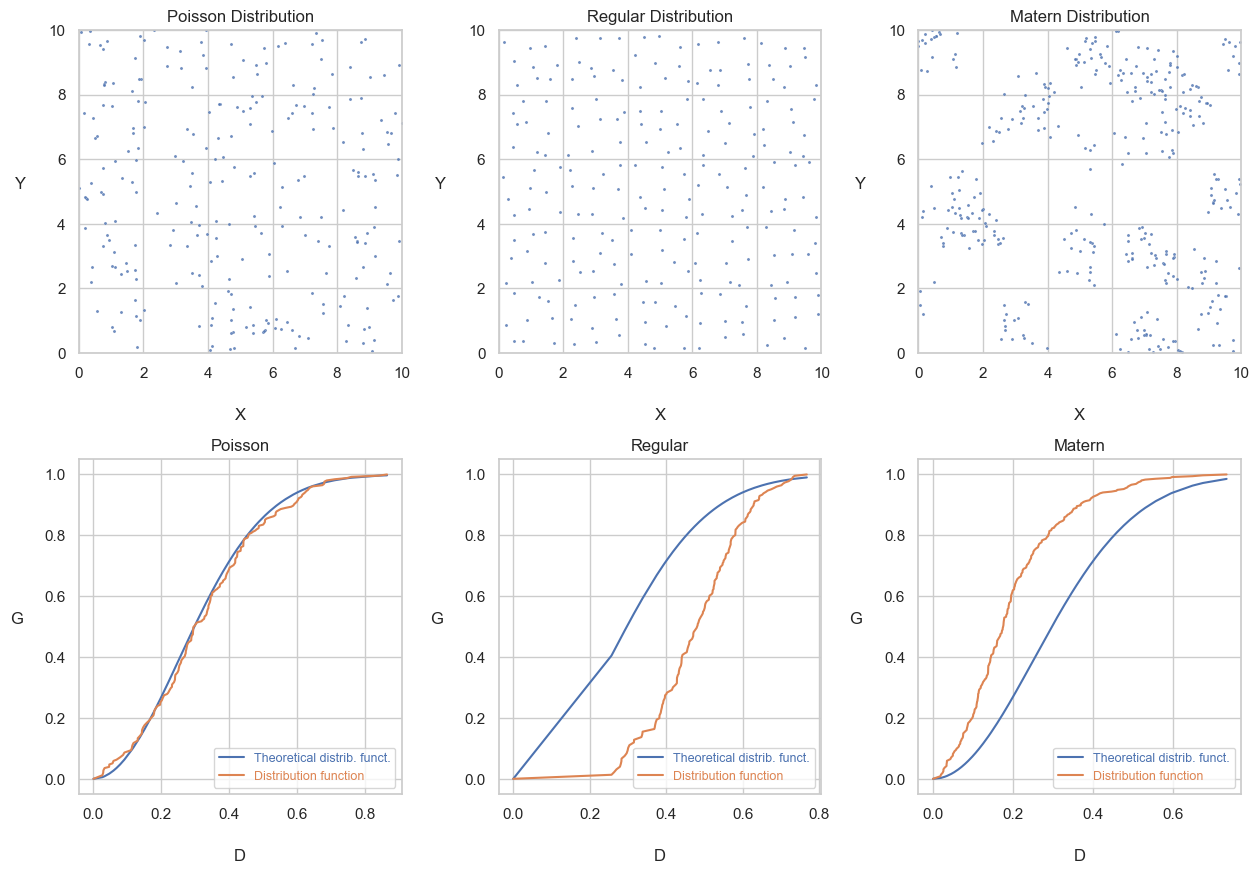

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[15,10])
plt.subplots_adjust(hspace=0.3, wspace=0.3)

def scatterplot(data, axes, title, x="X", y="Y", a=0.8, size=5):
    sns.scatterplot(data=data, x=x, y=y, alpha=a, s=size, ax=axes)
    axes.set_xlabel("X", rotation=0, labelpad=20)
    axes.set_ylabel("Y", rotation=0, labelpad=20)
    axes.set_aspect("equal", "box")
    axes.set_title(title)
    axes.set_xlim([floor(min(data[x])), ceil(max(data[x]))])
    axes.set_ylim([floor(min(data[y])), ceil(max(data[y]))])
    
def plot(data1, data2, axes, title, x="X", y="Y", a=0.8, size=5):
    axes.plot(data1[x], data1[y], label="Theoretical distrib. funct.")
    axes.plot(data2[x], data2[y], label="Distribution function")
    axes.legend(labelcolor="linecolor", loc="lower right", prop={'size': 9})
    axes.set_xlabel(x, rotation=0, labelpad=20)
    axes.set_ylabel(y, rotation=0, labelpad=20)
    axes.set_title(title)
    
scatterplot(poisson, axes[0,0], "Poisson Distribution")
scatterplot(regular, axes[0,1], "Regular Distribution")
scatterplot(materna, axes[0,2], "Matern Distribution")

plot(G_poisson, analysed_poisson, axes[1,0], "Poisson", "D", "G")
plot(G_regular, analysed_regular, axes[1,1], "Regular", "D", "G")
plot(G_materna, analysed_materna, axes[1,2], "Matern", "D", "G")

plt.show()

### Zadanie 2: Funkcja F (25 pkt)

Przygotuj funkcję `f_function()`, która będzie generować dane niezbędne do wykonania wykresu funkcji F analizowanego rozkładu punktów oraz funkcję `f_function_poisson()`, która będzie generować  dane niezbędne do wykonania wykresu teoretycznej funkcji F jednorodnego rozkładu Poissona danej wzorem: <br/>
$F(d) = 1 - exp(-\lambda \pi d^2)$ <br/>
gdzie: $\lambda$ - intensywność procesu, $d$ - odległość.

Następnie wykorzystaj przygotowane funkcje do wygnenerowania danych dla wszystkich przygotowanych rozkładów punktów. 

Przedstaw wyniki analizy graficznie w postaci wykresów liniowych funkcji F przygotowanych rozkładów punktów zestawionych z teoretyczną funkcją F jednorodnego rozkładu Poissona o intensywności $2.5$. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x3). Umieść analizowane rozkłady punktów w górnym wierszu, a wykresy funkcji F w dolnym wierszu figury. <br/>
Uwaga! Porównywane wykresy funkcji F powinny zaczynać się od $d=0$ (co może wymagać uzupełnienia danych o 0 w obrębie funkcji `f_function()`) i kończyć na wartości $d$, dla której funkcja F analizowanego rozkładu punktów osiąga wartość 1.

Algorytm postępowania:
1) Z wykorzystaniem procesu regularnego lub jednorodnego procesu Poissona generujemy w obrębie analizowanego rozkładu zestaw punktów pomiarowych.
2) Dla każdego z punktów rozkładu pomiarowego wyliczamy dystans do jego najbliższego sąsiada z analizowanego rozkładu $d_{min}$.
3) Konstruujemy funkcję F jako dystrybuantę rozkładu odległości: <br/>
    $F(d) = \frac{n_{d_{min} \le d}}{n}$  <br/>
    gdzie: $n_{d_{min} \le d}$ - liczba punktów rozkładu pomiarowego, dla których odległość do najbliższego sąsiada z analizowanego rozkładu $d_{min}$ jest mniejsza lub równa $d$, $n$ - liczba punktów rozkładu pomiarowego.
    
Uwaga! Liczba punktów rozkładu pomiarowego jest istotna i wpływa na dokładność rozwiązania.

#### a) Przygotowanie funkcji

In [9]:
def f_function(points, test_points):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów analizowanego rozkłądu opisane jako "X" i "Y".
    test_points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów pomiarowych, dla których mają zostać wyznaczone odległości
        do najbliższego sąsiada z analizowanego rozkładu opisane jako "X" i "Y".
    
    Returns
    -------
    f: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji F,
        - "F" - zawierającą wyliczone wartości funkcji F.
    """   
    D = [0]
    F = [0]
    for x, y in zip(test_points["X"], test_points["Y"]):
        dist = (points["X"]-x)**2 + (points["Y"]-y)**2
        dist = [np.sqrt(d) for d in dist]
        if 0 in dist:
            dist.remove(0)
        dist = min(dist)
        D.append(dist)
    D = sorted(D)
    Du = sorted(list(set(D)))
    for d in Du:
        if(d==0):
            continue
        F.append(len([dd for dd in D if dd<=d])/len(D))
    return pd.DataFrame({"D": Du, "F": F})
    
def f_function_poisson(d, intensity):
    """
    Parameters
    -------
    d: array
        Macierz zawierająca odległości, dla których ma zostać wyznaczona wartość funkcji F.
    intensity: float
        Liczba dodatnia określająca intensywność jednorodnego procesu Poissona.

    Returns
    -------
    f: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji F,
        - "F" - zawierającą wyliczone wartości funkcji F.
    """  
    F = []
    for dd in d:
        F.append(1-np.exp(-intensity*np.pi*dd*dd))
    return pd.DataFrame({"D": d, "F": F})

#### b) Wygenerowanie danych

In [10]:
points_tested = homogeneous_poisson_on_rectangle(2.5, lims, lims)
analysed_regular1 = f_function(regular, points_tested)
analysed_poisson1 = f_function(poisson, points_tested)
analysed_materna1 = f_function(materna, points_tested)
F_regular = f_function_poisson(analysed_regular1["D"], intensity)
F_poisson = f_function_poisson(analysed_poisson1["D"], intensity)
F_materna = f_function_poisson(analysed_materna1["D"], intensity)

#### c) Wizualizacja

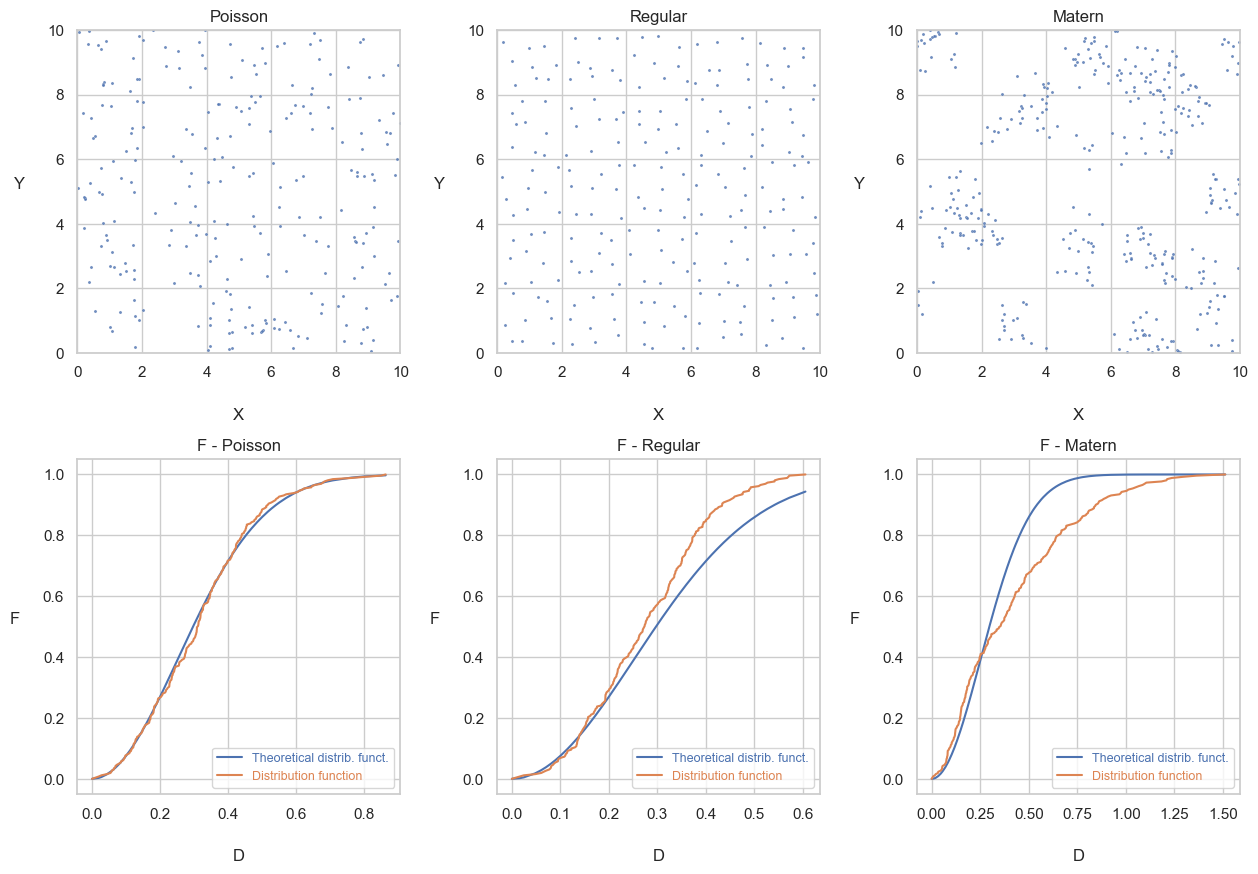

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[15,10])
plt.subplots_adjust(hspace=0.3, wspace=0.3)

scatterplot(poisson, axes[0,0], "Poisson")
scatterplot(regular, axes[0,1], "Regular")
scatterplot(materna, axes[0,2], "Matern")

plot(F_poisson, analysed_poisson1, axes[1,0], "F - Poisson", "D", "F")
plot(F_regular, analysed_regular1, axes[1,1], "F - Regular", "D", "F")
plot(F_materna, analysed_materna1, axes[1,2], "F - Matern", "D", "F")

plt.show()